In [1]:
from rockit import *
from casadi import SX, MX, vertcat, cross, fabs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
ocp = Ocp(t0=0, T=FreeTime(50))

In [3]:
Tmax = 0.000953
Wmax = 1570.79632679
Vmax = 6
a_1 = np.array([[1],[0],[0]])
a_2 = np.array([[0],[1],[0]])
a_3 = np.array([[0],[0],[1]])
a_mat = np.concatenate((a_1, a_2, a_3), axis=1)
I = np.array([[0.04, 0.00, 0.00],
              [0.00, 0.05, 0.02],
              [0.00, 0.02, 0.05]])
I_inv = np.linalg.inv(I)
I_rw = 6.25E-05
I_wheels = I_rw*(a_1*np.transpose(a_1) + a_2*np.transpose(a_2) + a_3*np.transpose(a_3))

In [4]:
q = ocp.state(4)
w = ocp.state(3)
Omega = ocp.state(3)
V = ocp.control(3)
# Q = ocp.algebraic(4, 4)
# Q[0,0] = 0
# Q[0,1] = -w[0]
# Q[0,2] = -w[1]
# Q[0,3] = -w[2]

# Q[1,0] = w[0]
# Q[1,1] = 0
# Q[1,2] = -w[2]
# Q[1,3] = w[1]

# Q[2,0] = w[1]
# Q[2,1] = w[2]
# Q[2,2] = 0
# Q[2,3] = w[0]

# Q[3,0] = w[2]
# Q[3,1] = -w[1]
# Q[3,2] = w[0]
# Q[3,3] = 0

In [5]:
# Assign derivatives

ocp.set_der(q, vertcat(
    -w[0]*q[1]-w[1]*q[2]-w[2]*q[3],
    w[0]*q[0] +w[1]*q[3]-w[2]*q[2],
    -w[0]*q[3]+w[1]*q[0]+w[2]*q[1],
    w[0]*q[2] -w[1]*q[1]+w[2]*q[0]
))
# ocp.set_der(q[0], -w[0]*q[1]-w[1]*q[2]-w[2]*q[3])
ocp.set_der(w, -(Tmax/Vmax)*a_mat@V + (Tmax/Wmax)*a_mat@Omega - cross(w, (I@w) + (I_wheels@w) + I_rw*(a_mat@Omega)))
ocp.set_der(Omega, (Tmax/(Vmax*I_rw))*V - (Tmax/(Wmax*I_rw))*Omega - a_mat.T@w)

In [6]:
# Constraints

ocp.subject_to(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2 == 1)
ocp.subject_to(-6 <= (V[0] <= 6))
ocp.subject_to(-6 <= (V[1] <= 6))
ocp.subject_to(-6 <= (V[2] <= 6))

In [7]:
# Boundary conditions

ocp.subject_to(ocp.at_t0(q) == np.array([1,0.0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(q) == np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))

ocp.subject_to(ocp.at_t0(w) == np.array([0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(w) == np.array([0,0.0,0.0]))

ocp.subject_to(ocp.at_t0(Omega) == np.array([0,0.0,0.0]))
ocp.subject_to(ocp.at_tf(Omega) == np.array([0,0.0,0.0]))

In [8]:
ocp.add_objective(ocp.T)

In [9]:
ocp.solver('ipopt')
method = MultipleShooting(N=200, intg='rk')
ocp.method(method)

In [10]:
sol = ocp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    26024
Number of nonzeros in inequality constraint Jacobian.:      604
Number of nonzeros in Lagrangian Hessian.............:    19605

Total number of variables............................:     2611
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2221
Total number of inequality c

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 1.8536131e+02 1.90e+00 1.05e+03  -8.6 8.56e+01    -  3.45e-03 8.13e-04h  1
  81r 1.8554962e+02 1.90e+00 1.04e+03  -8.6 8.57e+01    -  1.05e-02 2.20e-03h  1
  82r 1.8628371e+02 1.88e+00 1.03e+03  -8.6 8.57e+01    -  2.87e-03 8.56e-03h  1
  83r 1.8799300e+02 1.85e+00 1.86e+03  -8.6 8.60e+01    -  3.51e-03 1.99e-02h  1
  84r 1.8919359e+02 1.82e+00 2.02e+03  -8.6 8.66e+01    -  2.10e-02 1.39e-02h  1
  85r 1.8969965e+02 1.81e+00 2.05e+03  -8.6 8.70e+01    -  2.11e-03 5.82e-03h  1
  86r 1.9091403e+02 1.79e+00 1.99e+03  -8.6 8.72e+01    -  6.25e-03 1.39e-02h  1
  87r 1.9143920e+02 1.77e+00 1.96e+03  -8.6 8.76e+01    -  1.95e-02 6.00e-03h  1
  88r 1.9207883e+02 1.76e+00 1.84e+03  -8.6 8.78e+01    -  2.03e-02 7.29e-03h  1
  89r 1.9435501e+02 1.72e+00 2.07e+03  -8.6 8.80e+01    -  5.79e-03 2.59e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.9598049e+02 1.68e+00

 177r 4.0342161e+02 1.05e-01 1.26e+03  -8.6 4.88e+01    -  1.38e-02 1.78e-02h  1
 178r 4.0494520e+02 1.01e-01 1.28e+03  -8.6 4.82e+01    -  3.34e-03 3.16e-02f  1
 179r 4.0545328e+02 1.00e-01 1.27e+03  -8.6 4.70e+01    -  1.30e-02 1.08e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 4.0644175e+02 9.78e-02 1.24e+03  -8.6 4.66e+01    -  4.27e-03 2.12e-02h  1
 181r 4.0675997e+02 9.71e-02 1.23e+03  -8.6 4.58e+01    -  8.18e-03 6.95e-03h  1
 182r 4.0775625e+02 9.48e-02 1.23e+03  -8.6 4.55e+01    -  2.24e-03 2.19e-02h  1
 183r 4.0865771e+02 9.27e-02 1.30e+03  -8.6 4.47e+01    -  4.39e-03 2.01e-02h  1
 184r 4.0934131e+02 9.11e-02 1.30e+03  -8.6 4.40e+01    -  7.52e-03 1.55e-02h  1
 185r 4.1005307e+02 8.95e-02 1.28e+03  -8.6 4.35e+01    -  7.78e-03 1.64e-02h  1
 186r 4.1105892e+02 8.72e-02 1.45e+03  -8.6 4.29e+01    -  8.42e-04 2.35e-02h  1
 187r 4.1152724e+02 8.62e-02 1.43e+03  -8.6 4.20e+01    -  1.24e-02 1.11e-02h  1
 188r 4.1291640e+02 8.28e-02

 276r 4.2833633e+02 4.56e-02 5.78e+03  -8.6 1.84e+01  -4.4 5.71e-03 4.91e-03h  1
 277r 4.2833633e+02 4.56e-02 5.78e+03  -8.6 1.49e+00  -3.1 1.71e-05 2.61e-06h  1
 278r 4.2838011e+02 4.52e-02 5.68e+03  -8.6 6.12e+00  -3.5 1.97e-02 7.15e-03f  1
 279r 4.2840325e+02 4.51e-02 5.65e+03  -8.6 1.28e+01  -4.0 7.15e-03 1.81e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 4.2873669e+02 4.43e-02 5.61e+03  -8.6 1.98e+01  -4.5 4.69e-03 1.69e-02h  1
 281r 4.2873669e+02 4.43e-02 5.61e+03  -8.6 4.97e+00  -3.2 6.34e-06 6.56e-07h  1
 282r 4.2878093e+02 4.41e-02 5.57e+03  -8.6 7.21e+00  -3.6 7.29e-03 6.13e-03f  1
 283r 4.2880784e+02 4.40e-02 5.55e+03  -8.6 1.42e+01  -4.1 4.39e-03 1.89e-03h  1
 284r 4.2891805e+02 4.37e-02 5.54e+03  -8.6 2.09e+01  -4.6 8.19e-04 5.28e-03h  1
 285r 4.2891805e+02 4.37e-02 5.54e+03  -8.6 4.50e-01  -2.4 1.35e-05 1.76e-06h  1
 286r 4.2892061e+02 4.37e-02 5.39e+03  -8.6 1.48e+00  -2.8 3.11e-02 1.73e-03f  1
 287r 4.2896524e+02 4.32e-02

 369r 4.3853681e+02 1.61e-02 1.11e+03  -8.6 5.02e+00  -3.6 1.38e-02 2.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 4.3923536e+02 1.48e-02 1.09e+03  -8.6 1.07e+01  -4.1 7.39e-03 6.52e-02h  1
 371r 4.3923536e+02 1.48e-02 1.09e+03  -8.6 2.55e-01  -1.8 2.57e-05 4.56e-07h  1
 372r 4.3926941e+02 1.33e-02 9.76e+02  -8.6 3.35e-01  -2.3 1.26e-01 1.02e-01f  1
 373r 4.3940446e+02 1.14e-02 8.40e+02  -8.6 9.61e-01  -2.8 1.00e+00 1.41e-01f  1
 374r 4.3958030e+02 1.07e-02 7.83e+02  -8.6 2.62e+00  -3.3 5.33e-02 6.71e-02h  1
 375r 4.3986068e+02 1.02e-02 7.52e+02  -8.6 6.32e+00  -3.8 3.40e-01 4.44e-02h  1
 376r 4.4012058e+02 9.91e-03 7.37e+02  -8.6 1.26e+01  -4.2 3.20e-02 2.06e-02h  1
 377r 4.4021288e+02 9.88e-03 8.56e+02  -8.6 3.14e+01  -4.7 1.96e-03 2.94e-03h  1
 378r 4.4086934e+02 9.17e-03 8.17e+02  -8.6 1.35e+01  -4.3 6.23e-02 4.85e-02h  1
 379r 4.4087104e+02 9.17e-03 1.20e+03  -8.6 8.31e+00  -3.9 8.18e-03 2.04e-04f  1
iter    objective    inf_pr 

 465  2.0309038e+01 4.29e+00 5.23e+00  -1.7 8.60e+02    -  2.89e-03 9.47e-03h  1
 466  2.0738010e+01 4.27e+00 5.29e+00  -1.7 1.66e+03    -  3.84e-03 4.10e-03h  1
 467  2.1114323e+01 4.26e+00 5.32e+00  -1.7 2.71e+03    -  7.14e-04 4.02e-03h  1
 468  2.1311691e+01 4.25e+00 5.33e+00  -1.7 6.38e+02    -  2.75e-03 1.79e-03h  1
 469  2.1549679e+01 4.24e+00 5.33e+00  -1.7 3.28e+03    -  1.38e-03 2.75e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  2.1580418e+01 4.23e+00 5.33e+00  -1.7 5.03e+02    -  3.75e-03 2.78e-04h  1
 471  2.1997757e+01 4.22e+00 5.36e+00  -1.7 2.54e+03    -  2.51e-04 4.50e-03h  1
 472  2.2082849e+01 4.21e+00 5.36e+00  -1.7 5.00e+02    -  2.85e-03 7.73e-04h  1
 473  2.2422447e+01 4.20e+00 5.36e+00  -1.7 2.86e+03    -  4.59e-04 3.86e-03h  1
 474  2.2450350e+01 4.19e+00 5.36e+00  -1.7 4.91e+02    -  3.83e-03 2.60e-04h  1
 475  2.2903324e+01 4.17e+00 5.38e+00  -1.7 2.33e+03    -  2.58e-04 4.93e-03h  1
 476  2.2986513e+01 4.17e+00

 559r 6.7739523e+01 2.66e-04 9.17e+02  -5.5 1.01e+01    -  2.34e-03 1.16e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r 6.7740620e+01 2.84e-04 9.10e+02  -5.5 5.18e+00    -  1.16e-02 7.84e-03h  1
 561r 6.7741631e+01 2.82e-04 9.08e+02  -5.5 1.87e+01    -  1.90e-03 2.35e-03h  1
 562r 6.7742667e+01 2.73e-04 9.02e+02  -5.5 6.09e+00    -  1.37e-02 6.51e-03h  1
 563r 6.7744023e+01 2.92e-04 8.99e+02  -5.5 1.70e+01    -  1.35e-03 3.45e-03h  1
 564r 6.7744915e+01 2.70e-04 8.92e+02  -5.5 4.54e+00    -  1.57e-02 7.37e-03h  1
 565r 6.7746442e+01 3.09e-04 8.88e+02  -5.5 1.51e+01    -  1.17e-03 4.30e-03h  1
 566r 6.7747269e+01 2.82e-04 8.80e+02  -5.5 3.43e+00    -  1.10e-02 8.94e-03h  1
 567r 6.7748737e+01 2.42e-04 8.68e+02  -5.5 3.92e+00    -  9.40e-03 1.37e-02h  1
 568r 6.7750034e+01 3.34e-04 8.65e+02  -5.5 1.53e+01    -  7.98e-03 3.64e-03h  1
 569r 6.7751075e+01 2.96e-04 8.50e+02  -5.5 2.00e+00    -  2.28e-02 1.69e-02h  1
iter    objective    inf_pr 

 658r 7.8226718e+01 8.49e-03 4.30e+02  -5.5 1.09e+02    -  2.82e-02 1.83e-02h  1
 659r 7.8297321e+01 8.48e-03 4.14e+02  -5.5 2.03e+02    -  1.33e-03 2.77e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660r 7.8430732e+01 8.47e-03 4.25e+02  -5.5 1.74e+02    -  7.44e-03 6.05e-03h  1
 661r 7.8454334e+01 8.47e-03 4.23e+02  -5.5 2.48e+03    -  4.68e-05 9.51e-05h  1
 662r 7.8560892e+01 8.45e-03 4.55e+02  -5.5 1.47e+02    -  9.32e-03 5.75e-03h  1
 663r 7.8567759e+01 7.73e-03 3.85e+02  -5.5 3.28e-01  -4.5 1.00e+00 8.49e-02h  1
 664r 7.8610615e+01 7.72e-03 3.90e+02  -5.5 1.72e+02    -  1.33e-02 1.96e-03h  1
 665r 7.8795545e+01 7.76e-03 3.79e+02  -5.5 2.13e+02    -  4.60e-03 7.16e-03h  1
 666r 7.9077792e+01 7.87e-03 4.92e+02  -5.5 2.00e+02    -  4.12e-02 1.16e-02h  1
 667r 7.9216419e+01 7.88e-03 4.54e+02  -5.5 2.45e+02    -  1.40e-03 4.65e-03h  1
 668r 7.9429519e+01 7.90e-03 4.08e+02  -5.5 1.99e+02    -  5.18e-03 8.79e-03h  1
 669r 7.9445902e+01 7.18e-03

 753r 1.0375250e+02 1.40e-02 4.49e+02  -5.5 8.00e+02  -7.2 1.58e-03 3.07e-04h  3
 754r 1.0435548e+02 1.39e-02 4.21e+02  -5.5 6.20e+01  -6.7 9.95e-02 5.78e-02h  1
 755r 1.0445422e+02 1.35e-02 9.14e+02  -5.5 1.84e+01  -6.3 4.59e-01 3.15e-02h  1
 756r 1.0549174e+02 1.43e-02 8.74e+02  -5.5 7.68e+01  -6.8 3.63e-02 8.01e-02h  1
 757r 1.0632116e+02 1.24e-02 6.29e+02  -5.5 2.10e+01  -6.4 4.01e-01 2.25e-01h  1
 758r 1.0698771e+02 1.27e-02 6.29e+02  -5.5 1.04e+02  -6.8 6.93e-02 3.74e-02h  1
 759r 1.0757338e+02 1.16e-02 6.84e+02  -5.5 2.56e+01  -6.4 4.73e-01 1.30e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r 1.0826339e+02 1.20e-02 7.29e+02  -5.5 1.26e+02  -6.9 6.20e-02 3.15e-02h  1
 761r 1.0827209e+02 1.20e-02 7.34e+02  -5.5 2.34e+03  -7.4 3.56e-04 2.19e-05h  7
 762r 1.0881701e+02 1.21e-02 7.24e+02  -5.5 1.10e+02  -6.9 6.74e-02 2.91e-02h  1
 763r 1.0905288e+02 1.18e-02 6.74e+02  -5.5 1.26e+02    -  3.25e-02 2.57e-02h  1
 764r 1.0904831e+02 1.17e-02

 847r 1.1206876e+02 9.55e-03 1.03e+02  -8.2 3.45e+02  -7.0 1.49e-02 1.94e-03h  1
 848r 1.1206605e+02 8.41e-03 1.00e+02  -8.2 2.32e+01  -6.6 2.55e-02 1.19e-01h  1
 849r 1.1220623e+02 8.22e-03 1.03e+02  -8.2 9.01e+01  -7.0 2.36e-02 3.36e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850r 1.1220483e+02 6.98e-03 1.45e+02  -8.2 2.67e+01  -6.6 3.37e-02 1.51e-01h  1
 851r 1.1221230e+02 6.98e-03 7.95e+02  -8.2 3.16e+02  -7.1 5.32e-03 9.78e-04h  1
 852r 1.1225452e+02 7.01e-03 7.93e+02  -8.2 6.58e+02  -7.6 4.07e-05 2.94e-03h  1
 853r 1.1225451e+02 7.01e-03 8.00e+02  -8.2 1.86e+01  -6.2 1.50e-02 4.66e-05h  1
 854r 1.1225582e+02 7.00e-03 8.96e+02  -8.2 1.64e+03  -6.7 2.93e-03 1.49e-04f  1
 855r 1.1219831e+02 6.59e-03 8.57e+02  -8.2 1.17e+02  -7.2 4.21e-02 3.90e-02h  1
 856r 1.1219945e+02 6.56e-03 8.24e+02  -8.2 4.05e+01  -6.8 4.20e-02 4.58e-03h  1
 857r 1.1219279e+02 6.42e-03 8.54e+02  -8.2 2.12e+01  -6.3 2.70e-03 2.08e-02h  1
 858r 1.1208527e+02 6.00e-03

 944r 1.1410335e+02 2.14e-03 7.51e+02  -8.2 2.15e+01  -6.3 1.12e-02 1.10e-02f  1
 945r 1.1416157e+02 2.14e-03 7.48e+02  -8.2 9.82e+01  -6.8 1.47e-03 4.45e-03h  1
 946r 1.1419743e+02 2.12e-03 7.38e+02  -8.2 2.46e+01  -6.4 5.49e-04 1.28e-02f  1
 947r 1.1421855e+02 2.12e-03 7.37e+02  -8.2 1.39e+02  -6.8 5.15e-03 1.11e-03f  1
 948r 1.1425009e+02 2.10e-03 1.07e+03  -8.2 2.79e+01  -6.4 2.88e-02 9.77e-03f  1
 949r 1.1429487e+02 2.10e-03 1.06e+03  -8.2 2.05e+02  -6.9 6.51e-04 1.60e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r 1.1432875e+02 2.08e-03 9.79e+02  -8.2 3.34e+01  -6.5 2.04e-03 8.71e-03h  1
 951r 1.1434532e+02 2.08e-03 1.14e+03  -8.2 2.45e+02  -6.9 3.02e-03 4.62e-04h  1
 952r 1.1441966e+02 2.06e-03 1.08e+03  -8.2 3.87e+01  -6.5 1.27e-02 1.61e-02h  1
 953r 1.1444464e+02 2.07e-03 1.08e+03  -8.2 7.25e+02  -7.0 6.59e-05 2.47e-04h  1
 954r 1.1447258e+02 2.06e-03 1.07e+03  -8.2 4.64e+01  -6.6 4.70e-04 5.02e-03f  1
 955r 1.1451114e+02 2.06e-03

1041r 1.1805383e+02 3.22e-03 1.27e+03  -8.2 3.49e+00  -5.6 2.41e-01 6.82e-02f  1
1042r 1.1805391e+02 3.22e-03 1.22e+03  -8.2 1.03e+01  -6.1 2.67e-01 2.35e-04h  1
1043r 1.1807139e+02 3.18e-03 1.11e+03  -8.2 3.02e+01  -6.6 1.12e-02 1.51e-02h  1
1044r 1.1820383e+02 3.27e-03 1.06e+03  -8.2 1.23e+02  -7.1 4.42e-02 1.47e-02h  1
1045r 1.1820382e+02 3.27e-03 1.06e+03  -8.2 2.53e+01  -6.6 1.04e-03 1.95e-05h  1
1046r 1.1820587e+02 3.27e-03 1.06e+03  -8.2 9.45e+01  -7.1 2.32e-04 1.20e-03f  1
1047r 1.1832785e+02 3.19e-03 1.05e+03  -8.2 4.16e+01  -6.7 9.03e-03 5.56e-02f  1
1048r 1.1832785e+02 3.19e-03 1.05e+03  -8.2 2.58e+01  -5.4 1.17e-05 3.59e-07h  2
1049r 1.1832785e+02 3.19e-03 9.54e+02  -8.2 1.15e+00  -4.9 2.94e-01 1.50e-06h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050r 1.1833247e+02 2.93e-03 8.74e+02  -8.2 2.12e+00  -5.4 1.00e+00 8.29e-02h  1
1051r 1.1833856e+02 2.84e-03 8.48e+02  -8.2 5.63e+00  -5.9 7.73e-01 2.90e-02h  1
1052r 1.1835542e+02 2.61e-03

1141r 1.2901790e+02 2.68e-03 1.01e+03  -8.2 6.48e+02  -9.5 8.23e-04 2.31e-04h  1
1142r 1.2924415e+02 2.89e-03 1.00e+03  -8.2 1.22e+02  -9.1 1.80e-03 5.83e-03f  1
1143r 1.2938061e+02 2.95e-03 9.97e+02  -8.2 1.05e+02    -  4.97e-03 3.96e-03f  1
1144r 1.2968559e+02 3.22e-03 9.76e+02  -8.2 5.28e+01  -8.7 6.05e-03 2.13e-02f  1
1145r 1.2976803e+02 3.25e-03 9.75e+02  -8.2 2.98e+02  -9.1 4.06e-03 8.31e-04h  1
1146r 1.2980218e+02 3.25e-03 9.75e+02  -8.2 3.04e+02  -9.6 2.08e-03 3.34e-04h  1
1147r 1.2995194e+02 3.34e-03 9.74e+02  -8.2 7.63e+02 -10.1 3.40e-04 5.84e-04f  1
1148r 1.3020960e+02 3.61e-03 4.36e+03  -8.2 3.85e+03  -9.7 1.74e-04 1.98e-04h  1
1149r 1.3033748e+02 3.67e-03 4.38e+03  -8.2 4.14e+02  -9.2 1.24e-03 9.13e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150r 1.3057746e+02 3.76e-03 4.30e+03  -8.2 4.86e+01  -8.8 1.71e-02 1.76e-02f  1
1151r 1.3078598e+02 3.77e-03 4.21e+03  -8.2 3.59e+01  -8.4 3.11e-03 2.59e-02f  1
1152r 1.3091701e+02 3.83e-03

1234r 1.3788392e+02 3.93e-05 4.87e+02  -8.2 1.29e+02    -  2.54e-02 5.99e-05h 10
1235r 1.3788391e+02 3.93e-05 4.87e+02  -8.2 1.31e+02    -  5.08e-03 1.53e-06h 16
1236r 1.3774084e+02 3.15e-04 4.72e+02  -8.2 1.31e+02    -  3.04e-02 3.04e-02s 18
1237r 1.3771909e+02 3.38e-04 4.50e+02  -8.2 6.78e+01    -  4.64e-02 4.64e-02s 18
1238r 1.3774334e+02 2.79e-04 3.86e+02  -8.2 4.91e+00    -  1.42e-01 1.42e-01s 18
1239r 1.3781142e+02 2.13e-04 3.37e+02  -8.2 5.47e+00    -  1.26e-01 1.26e-01s 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240r 1.3810969e+02 2.78e-04 3.11e+02  -8.2 1.94e+01    -  7.80e-02 7.80e-02s 18
1241r 1.3798702e+02 2.91e-04 2.29e+02  -8.2 2.00e+00  -7.7 2.66e-01 2.66e-01s 18
1242r 1.3799360e+02 2.71e-04 2.13e+02  -8.2 1.16e+00  -7.3 6.82e-02 6.82e-02s 18
1243r 1.3808785e+02 2.89e-04 1.94e+02  -8.2 4.47e+00  -7.8 8.83e-02 8.83e-02s 18
1244r 1.3791002e+02 3.64e-04 1.64e+02  -8.2 4.70e+00  -8.3 1.54e-01 1.54e-01s 18
1245r 1.3793203e+02 3.30e-04

1332  1.1320523e+02 1.67e-01 3.10e+00  -5.7 1.23e+02  -4.7 4.04e-01 1.08e-02f  1
1333  1.1210306e+02 1.65e-01 3.49e+00  -5.7 4.84e+02  -5.2 4.77e-03 1.39e-02f  1
1334  1.1187366e+02 1.64e-01 3.48e+00  -5.7 1.29e+02  -4.8 1.38e-01 6.29e-03f  1
1335  1.1091263e+02 1.62e-01 3.87e+00  -5.7 5.31e+02  -5.3 1.17e-02 1.19e-02f  1
1336  1.1070460e+02 1.61e-01 3.86e+00  -5.7 1.39e+02  -4.8 4.04e-01 5.57e-03f  1
1337  1.0963009e+02 1.59e-01 4.45e+00  -5.7 5.81e+02  -5.3 1.76e-02 1.29e-02f  1
1338  1.0892490e+02 1.56e-01 4.52e+00  -5.7 1.49e+02  -4.9 1.59e-01 1.87e-02f  1
1339  1.0861632e+02 1.55e-01 4.55e+00  -5.7 5.58e+02  -5.4 1.40e-02 3.86e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340  1.0812476e+02 1.53e-01 4.56e+00  -5.7 1.37e+02  -4.9 1.43e-02 1.29e-02f  1
1341  1.0735546e+02 1.52e-01 4.91e+00  -5.7 6.88e+02  -5.4 7.38e-03 8.96e-03f  1
1342  1.0724126e+02 1.51e-01 4.90e+00  -5.7 1.71e+02  -5.0 5.99e-02 2.89e-03f  1
1343  1.0685066e+02 1.51e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430  8.3036738e+01 5.24e-02 4.92e+00  -5.7 1.23e+02  -5.4 9.72e-02 1.14e-03h  1
1431  8.2742362e+01 5.17e-02 4.91e+00  -5.7 3.18e+02  -5.9 7.18e-03 1.37e-02f  1
1432  8.2529367e+01 5.03e-02 4.80e+00  -5.7 1.23e+02  -5.5 8.73e-03 2.70e-02h  1
1433  8.2435963e+01 4.92e-02 4.70e+00  -5.7 5.80e+01  -5.0 5.09e-02 2.11e-02h  1
1434  8.2085909e+01 4.76e-02 4.56e+00  -5.7 1.44e+02  -5.5 1.99e-02 3.42e-02f  1
1435  8.1986833e+01 4.66e-02 4.46e+00  -5.7 6.33e+01  -5.1 5.28e-02 2.13e-02h  1
1436  8.1804300e+01 4.59e-02 4.39e+00  -5.7 1.61e+02  -5.6 1.14e-01 1.70e-02h  1
1437  8.1740161e+01 4.52e-02 4.33e+00  -5.7 6.61e+01  -5.2 1.28e-02 1.33e-02h  1
1438  8.1346093e+01 4.37e-02 4.20e+00  -5.7 1.72e+02  -5.6 8.48e-02 3.55e-02f  1
1439  8.1123013e+01 4.19e-02 4.02e+00  -5.7 7.85e+01  -5.2 4.67e-02 4.30e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1440  8.1076175e+01 4.17e-02

1526  7.6004582e+01 7.12e-03 6.66e-01  -5.7 4.98e+01  -5.2 1.58e-01 1.40e-02h  1
1527  7.6051283e+01 6.80e-03 6.47e-01  -5.7 2.01e+02  -5.6 2.75e-02 4.39e-02h  1
1528  7.6050517e+01 6.48e-03 6.21e-01  -5.7 5.59e+01  -5.2 9.17e-02 4.73e-02h  1
1529  7.6056140e+01 6.46e-03 6.19e-01  -5.7 2.06e+02  -5.7 3.30e-02 2.97e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530  7.6062455e+01 5.91e-03 5.82e-01  -5.7 5.59e+01  -5.3 2.16e-02 8.60e-02h  1
1531  7.6064844e+01 5.90e-03 5.81e-01  -5.7 2.48e+02  -5.7 1.73e-02 1.01e-03h  1
1532  7.6044864e+01 5.66e-03 5.60e-01  -5.7 5.84e+01  -5.3 1.27e-02 4.16e-02h  1
1533  7.6081679e+01 5.61e-03 5.56e-01  -5.7 3.48e+02  -5.8 1.05e-02 7.45e-03h  1
1534  7.6096121e+01 5.39e-03 5.39e-01  -5.7 7.40e+01  -5.4 6.44e-02 3.94e-02h  1
1535  7.6126576e+01 5.37e-03 5.37e-01  -5.7 4.63e+02  -5.9 7.10e-03 3.96e-03h  3
1536  7.6161412e+01 5.03e-03 5.15e-01  -5.7 8.71e+01  -5.4 1.52e-02 6.38e-02h  1
1537  7.6171367e+01 5.02e-03

1621  7.6498427e+01 1.18e-02 9.52e-01  -5.7 2.48e+02    -  6.50e-03 6.26e-03h  1
1622  7.6475716e+01 1.18e-02 9.50e-01  -5.7 8.78e+02    -  3.19e-04 2.25e-03f  1
1623  7.6446093e+01 1.17e-02 9.48e-01  -5.7 1.04e+03    -  2.39e-03 2.25e-03f  1
1624  7.6376636e+01 1.17e-02 9.44e-01  -5.7 1.41e+03    -  3.52e-03 4.55e-03f  1
1625  7.6372586e+01 1.17e-02 9.43e-01  -5.7 6.67e+03    -  7.47e-04 5.27e-05f  1
1626  7.6361850e+01 1.17e-02 9.43e-01  -5.7 5.31e+03    -  2.05e-04 1.99e-04f  1
1627  7.6343865e+01 1.16e-02 9.43e-01  -5.7 6.28e+03    -  4.33e-04 3.20e-04f  1
1628  7.6264759e+01 1.02e-02 9.43e-01  -5.7 7.62e+03    -  4.49e-04 9.49e-04f  1
1629  7.6236253e+01 1.02e-02 9.42e-01  -5.7 6.88e+03    -  3.58e-04 3.74e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630  7.6213131e+01 1.02e-02 9.42e-01  -5.7 7.02e+03    -  1.14e-03 3.14e-04f  1
1631  7.6132825e+01 1.01e-02 9.39e-01  -5.7 2.79e+03    -  3.74e-04 3.33e-03f  1
1632  7.6097658e+01 1.01e-02

1722  7.3524817e+01 1.65e-02 7.24e-01  -5.7 4.72e+05    -  1.08e-06 6.38e-06f  1
1723  7.3518302e+01 1.65e-02 7.24e-01  -5.7 1.33e+03    -  2.70e-04 7.12e-04f  1
1724  7.3460548e+01 1.64e-02 7.21e-01  -5.7 1.57e+03  -7.3 7.89e-03 4.66e-03f  1
1725  7.3457767e+01 1.64e-02 7.21e-01  -5.7 2.93e+03    -  1.92e-03 1.08e-04h  1
1726  7.3442914e+01 1.63e-02 7.16e-01  -5.7 3.54e+02    -  1.77e-03 6.62e-03h  1
1727  7.3423706e+01 1.63e-02 7.16e-01  -5.7 9.49e+03    -  2.18e-04 2.48e-04f  1
1728  7.3401847e+01 1.63e-02 7.14e-01  -5.7 1.33e+03    -  1.78e-03 2.12e-03h  1
1729  7.3352790e+01 1.63e-02 7.14e-01  -5.7 2.08e+05    -  3.92e-06 2.76e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730  7.3349988e+01 1.61e-02 7.08e-01  -5.7 1.45e+02    -  1.95e-02 8.21e-03h  1
1731  7.3334107e+01 1.61e-02 7.06e-01  -5.7 4.57e+02    -  7.84e-03 3.17e-03h  1
1732  7.3294794e+01 1.60e-02 7.00e-01  -5.7 4.76e+02    -  3.33e-03 8.25e-03f  1
1733  7.3287401e+01 1.59e-02

1817  7.1784735e+01 6.10e-03 1.26e-01  -5.7 1.33e+03  -6.3 1.15e-03 1.58e-04h  5
1818  7.1813626e+01 6.39e-03 1.25e-01  -5.7 5.09e+01  -5.9 6.18e-02 2.56e-02h  2
1819  7.1844911e+01 6.40e-03 1.21e-01  -5.7 1.64e+01  -5.5 2.14e-02 8.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820  7.1851071e+01 6.26e-03 1.18e-01  -5.7 2.65e+01  -6.0 1.73e-02 2.22e-02h  1
1821  7.1856693e+01 6.20e-03 1.17e-01  -5.7 1.84e+01  -5.5 5.51e-02 1.12e-02h  1
1822  7.1871242e+01 6.15e-03 1.16e-01  -5.7 6.98e+01  -6.0 3.40e-03 8.18e-03h  3
1823  7.1916399e+01 5.68e-03 1.15e-01  -5.7 2.45e+01  -5.6 5.02e-02 7.66e-02h  1
1824  7.1928827e+01 5.65e-03 1.14e-01  -5.7 1.17e+02  -6.1 2.26e-02 4.21e-03h  3
1825  7.1961564e+01 5.41e-03 1.13e-01  -5.7 2.98e+01  -5.6 1.87e-02 4.21e-02h  2
1826  7.1967114e+01 5.41e-03 1.13e-01  -5.7 1.76e+02  -6.1 1.52e-02 1.30e-03h  5
1827  7.1993681e+01 5.27e-03 1.11e-01  -5.7 3.52e+01  -5.7 2.55e-02 2.62e-02h  3
1828  7.1998237e+01 5.26e-03

1914  7.0600247e+01 8.10e-03 6.51e-01  -5.7 3.18e+02    -  9.89e-03 4.93e-04h  1
1915  7.0596223e+01 8.01e-03 6.43e-01  -5.7 6.75e+01    -  4.21e-03 1.12e-02f  1
1916  7.0563251e+01 7.95e-03 6.39e-01  -5.7 3.07e+02    -  5.31e-03 7.59e-03f  1
1917  7.0551381e+01 7.94e-03 6.38e-01  -5.7 1.73e+03    -  1.12e-03 1.22e-03f  1
1918  7.0536573e+01 7.87e-03 6.32e-01  -5.7 2.79e+02    -  6.53e-03 8.75e-03h  1
1919  7.0481914e+01 7.84e-03 6.30e-01  -5.7 2.77e+03    -  2.63e-04 3.73e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920  7.0458542e+01 7.56e-03 6.07e-01  -5.7 2.51e+02    -  4.51e-03 3.64e-02h  1
1921  7.0456221e+01 7.53e-03 6.05e-01  -5.7 5.35e+01    -  1.74e-02 3.94e-03h  1
1922  7.0443870e+01 7.52e-03 6.04e-01  -5.7 5.54e+02    -  6.12e-03 1.60e-03h  1
1923  7.0437175e+01 7.51e-03 6.04e-01  -5.7 3.05e+03    -  8.87e-04 5.87e-04h  1
1924  7.0416704e+01 7.49e-03 6.02e-01  -5.7 2.65e+03    -  8.03e-04 2.50e-03f  1
1925  7.0432866e+01 7.25e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010  6.9910104e+01 5.54e-03 2.64e+00  -5.7 2.70e+03    -  3.12e-04 3.22e-03f  1
2011  6.9908947e+01 5.51e-03 2.63e+00  -5.7 5.74e+01    -  5.58e-03 6.24e-03h  1
2012  6.9900292e+01 5.50e-03 2.62e+00  -5.7 2.70e+03    -  4.12e-03 1.02e-03f  1
2013  6.9899445e+01 5.45e-03 2.60e+00  -5.7 1.77e+01    -  8.43e-03 1.02e-02h  1
2014  6.9885696e+01 5.44e-03 2.59e+00  -5.7 2.63e+03    -  1.40e-03 1.62e-03f  1
2015  6.9885357e+01 5.22e-03 2.53e+00  -5.7 2.99e+00    -  2.56e-02 4.11e-02h  1
2016  6.9862193e+01 5.21e-03 2.52e+00  -5.7 2.91e+03    -  1.64e-03 2.54e-03f  1
2017  6.9861656e+01 5.15e-03 2.49e+00  -5.7 9.70e+00    -  1.17e-02 1.15e-02h  1
2018  6.9853496e+01 5.14e-03 2.48e+00  -5.7 2.37e+03    -  3.17e-03 1.06e-03f  1
2019  6.9851992e+01 5.10e-03 2.47e+00  -5.7 5.34e+01    -  6.26e-03 8.68e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020  6.9824521e+01 5.09e-03

2109  6.9365016e+01 5.99e-03 7.45e-01  -5.7 4.47e+00    -  2.55e-02 2.56e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2110  6.9362423e+01 5.98e-03 7.44e-01  -5.7 1.73e+03    -  3.59e-03 4.00e-04h  1
2111  6.9359738e+01 5.89e-03 7.33e-01  -5.7 4.61e+01    -  5.65e-03 1.53e-02h  1
2112  6.9358703e+01 5.88e-03 7.32e-01  -5.7 1.41e+02    -  1.15e-02 1.83e-03f  1
2113  6.9351708e+01 5.71e-03 7.10e-01  -5.7 5.59e+01    -  2.03e-03 2.98e-02h  1
2114  6.9313508e+01 5.42e-03 6.73e-01  -5.7 1.97e+02  -6.7 1.81e-02 5.19e-02f  1
2115  6.9312808e+01 5.27e-03 6.55e-01  -5.7 1.07e+01    -  1.70e-02 2.65e-02h  1
2116  6.9292319e+01 5.24e-03 6.50e-01  -5.7 6.99e+02  -7.1 2.44e-02 7.71e-03f  1
2117  6.9271667e+01 5.23e-03 6.49e-01  -5.7 2.77e+03    -  1.20e-04 1.97e-03f  1
2118  6.9270150e+01 5.15e-03 6.39e-01  -5.7 2.72e+01    -  1.04e-02 1.51e-02h  1
2119  6.9269147e+01 5.14e-03 6.39e-01  -5.7 3.57e+02    -  1.60e-02 7.17e-04h  1
iter    objective    inf_pr 

2201  6.9162795e+01 2.61e-03 2.49e-01  -5.7 8.97e+02  -6.6 3.49e-03 3.49e-03s 15
2202  6.9163102e+01 2.59e-03 2.48e-01  -5.7 2.23e+02    -  5.59e-03 5.59e-03s 15
2203  6.9163726e+01 2.59e-03 2.48e-01  -5.7 2.24e+02    -  7.50e-04 7.50e-04s 15
2204  6.9166233e+01 2.59e-03 2.47e-01  -5.7 1.08e+02  -6.1 3.93e-03 3.93e-03s 15
2205  6.9175376e+01 2.58e-03 2.29e-01  -5.7 2.42e+01  -5.7 4.84e-02 4.84e-02s 15
2206  6.9181738e+01 2.54e-03 2.24e-01  -5.7 8.92e+01    -  1.57e-02 1.57e-02s 15
2207  6.9186215e+01 2.52e-03 2.23e-01  -5.7 1.46e+02  -6.2 5.88e-03 5.88e-03s 15
2208  6.9187161e+01 2.52e-03 2.23e-01  -5.7 9.10e+02  -6.7 2.14e-04 2.14e-04s 15
2209  6.9193147e+01 2.51e-03 2.21e-01  -5.7 2.26e+02  -6.2 6.09e-03 6.09e-03s 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210r 6.9193147e+01 2.51e-03 9.99e+02  -2.6 0.00e+00  -5.8 0.00e+00 0.00e+00R  1
2211r 6.9196575e+01 6.32e-04 9.98e+02  -2.6 3.04e+02    -  9.39e-04 9.91e-04f  1
2212r 6.9203163e+01 2.75e-04

2299  6.8634782e+01 3.82e-03 9.19e-01  -5.7 2.65e+03    -  2.31e-03 2.23e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  6.8634450e+01 3.73e-03 8.96e-01  -5.7 3.84e+00    -  2.19e-02 2.49e-02h  1
2301  6.8590506e+01 5.13e-03 8.94e-01  -5.7 5.00e+03    -  1.35e-03 1.80e-03f  1
2302  6.8590443e+01 5.06e-03 8.82e-01  -5.7 4.02e+01    -  3.75e-02 1.35e-02h  1
2303  6.8575486e+01 5.49e-03 8.82e-01  -5.7 7.73e+03    -  1.18e-03 3.82e-04f  1
2304  6.8574984e+01 5.36e-03 8.62e-01  -5.7 2.44e+00    -  2.30e-02 2.32e-02h  1
2305  6.8560736e+01 5.36e-03 8.61e-01  -5.7 1.30e+04    -  2.30e-04 2.15e-04f  1
2306  6.8556656e+01 5.35e-03 8.59e-01  -5.7 3.06e+02    -  3.16e-03 2.63e-03h  1
2307  6.8517587e+01 5.22e-03 8.38e-01  -5.7 3.12e+02  -6.7 2.53e-02 2.47e-02f  1
2308  6.8517663e+01 5.18e-03 8.32e-01  -5.7 1.63e+03    -  6.24e-04 7.34e-03h  1
2309  6.8517509e+01 5.17e-03 8.31e-01  -5.7 6.07e+01    -  7.10e-03 1.13e-03f  1
iter    objective    inf_pr 

2391  6.8459830e+01 1.41e-03 2.60e-01  -5.7 1.29e+01  -5.1 2.69e-02 4.34e-02h  3
2392  6.8462278e+01 1.40e-03 2.59e-01  -5.7 5.44e+01  -5.6 2.89e-02 3.68e-03h  5
2393  6.8470538e+01 1.38e-03 2.52e-01  -5.7 1.51e+01  -5.1 1.97e-02 3.48e-02h  3
2394  6.8473880e+01 1.38e-03 2.51e-01  -5.7 6.79e+01  -5.6 2.88e-02 3.97e-03h  5
2395  6.8483624e+01 1.36e-03 2.44e-01  -5.7 1.76e+01  -5.2 3.80e-02 3.40e-02h  3
2396  6.8486554e+01 1.35e-03 2.43e-01  -5.7 8.72e+01  -5.7 1.09e-02 2.71e-03h  6
2397  6.8492987e+01 1.33e-03 2.39e-01  -5.7 2.07e+01  -5.2 5.34e-02 1.85e-02h  4
2398  6.8494681e+01 1.33e-03 2.39e-01  -5.7 1.16e+02  -5.7 5.75e-03 1.19e-03h  7
2399  6.8499507e+01 1.32e-03 2.36e-01  -5.7 2.44e+01  -5.3 2.45e-02 1.18e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  6.8595576e+01 1.02e-02 2.21e-01  -5.7 1.60e+02  -5.8 5.11e-03 5.19e-02w  1
2401  6.8611747e+01 1.00e-02 2.16e-01  -5.7 3.20e+01  -5.3 5.00e-02 3.09e-02w  1
2402  6.8614162e+01 1.00e-02

2487  6.7475373e+01 7.23e-06 1.92e-02  -5.7 6.87e+00    -  1.06e-02 1.06e-02s 14
2488  6.7477677e+01 1.55e-05 1.91e-02  -5.7 2.79e+01  -5.6 1.03e-02 1.03e-02s 14
2489  6.7480827e+01 3.15e-05 1.91e-02  -5.7 2.42e+02  -6.1 1.66e-03 1.66e-03s 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2490  6.7485267e+01 6.22e-05 1.90e-02  -5.7 3.37e+01  -5.7 1.64e-02 1.64e-02s 14
2491  6.7487366e+01 6.90e-05 1.90e-02  -5.7 1.00e+02  -6.1 2.62e-03 2.62e-03s 14
2492  6.7488127e+01 6.99e-05 1.90e-02  -5.7 2.10e+03    -  4.30e-04 4.30e-04s 14
2493  6.7488330e+01 6.96e-05 1.89e-02  -5.7 1.55e+01    -  3.94e-03 3.94e-03s 14
2494  6.7488984e+01 6.77e-05 1.85e-02  -5.7 1.18e+01    -  2.70e-02 2.70e-02s 14
2495  6.7493738e+01 7.48e-05 1.85e-02  -5.7 4.54e+01  -5.7 1.30e-02 1.30e-02s 14
2496r 6.7493738e+01 7.48e-05 9.99e+02  -4.1 0.00e+00  -5.3 0.00e+00 0.00e+00R  1
2497r 6.7494647e+01 1.88e-05 9.80e+02  -4.1 9.59e+00    -  2.79e-02 9.90e-04f  1
2498r 6.7520388e+01 1.41e-04

2582  6.7699168e+01 7.94e-03 6.27e-01  -5.7 2.30e+03    -  2.13e-03 2.25e-03h  1
2583  6.7698504e+01 7.94e-03 6.27e-01  -5.7 2.20e+04    -  3.33e-04 1.01e-04h  1
2584  6.7695579e+01 7.88e-03 6.22e-01  -5.7 1.65e+02    -  2.37e-03 7.40e-03f  1
2585  6.7683879e+01 7.87e-03 6.21e-01  -5.7 6.72e+02  -6.7 1.37e-03 2.18e-03f  1
2586  6.7682960e+01 7.80e-03 6.16e-01  -5.7 1.43e+02    -  1.24e-02 8.26e-03h  1
2587  6.7681280e+01 7.68e-03 6.06e-01  -5.7 1.95e+02  -7.2 4.34e-03 1.48e-02f  1
2588  6.7606829e+01 1.01e-02 6.01e-01  -5.7 1.13e+03  -6.7 1.78e-03 8.30e-03f  1
2589  6.7601570e+01 1.01e-02 6.00e-01  -5.7 2.37e+02  -6.3 4.19e-02 2.73e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2590  6.7599309e+01 1.00e-02 5.92e-01  -5.7 1.09e+02  -6.8 1.06e-02 1.31e-02h  1
2591  6.7544363e+01 1.21e-02 5.77e-01  -5.7 2.75e+02  -6.4 3.98e-02 2.54e-02f  1
2592  6.7541964e+01 1.21e-02 5.77e-01  -5.7 2.28e+03    -  1.54e-03 1.33e-04h  1
2593  6.7535187e+01 1.21e-02

2675r 1.0001828e+02 1.60e-02 4.62e+02  -6.2 4.45e+01  -6.5 4.29e-02 6.80e-02h  1
2676r 1.0004948e+02 1.60e-02 4.64e+02  -6.2 3.00e+02  -6.9 2.82e-03 9.76e-04h  1
2677r 1.0006960e+02 1.59e-02 4.88e+02  -6.2 1.19e+02  -6.5 3.05e-02 2.34e-03h  1
2678r 1.0007857e+02 1.59e-02 5.33e+02  -6.2 1.70e+01  -6.1 1.97e-02 3.85e-03h  1
2679r 1.0008638e+02 1.57e-02 5.56e+02  -6.2 7.24e+00  -5.7 4.64e-02 9.84e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2680r 1.0021536e+02 1.50e-02 5.26e+02  -6.2 1.87e+01  -6.1 4.67e-02 4.94e-02h  1
2681r 1.0038884e+02 1.47e-02 4.36e+02  -6.2 6.34e+01  -6.6 2.22e-03 2.03e-02h  1
2682r 1.0041604e+02 1.47e-02 4.45e+02  -6.2 6.46e+05  -7.1 1.20e-06 9.07e-07h  1
2683r 1.0043039e+02 1.47e-02 6.62e+02  -6.2 2.23e+02  -6.7 1.39e-02 9.91e-04h  1
2684r 1.0043277e+02 1.47e-02 6.74e+02  -6.2 2.30e+01  -6.2 2.34e-02 7.73e-04f  1
2685r 1.0046392e+02 1.47e-02 7.10e+02  -6.2 3.10e+02  -6.7 4.39e-03 1.69e-03f  1
2686r 1.0046560e+02 1.47e-02

2768r 1.1026281e+02 1.08e-02 1.78e+03  -6.2 1.28e+02  -6.6 8.73e-02 4.07e-03f  1
2769r 1.1112788e+02 1.33e-02 1.82e+03  -6.2 3.67e+02  -7.1 2.27e-03 1.10e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2770r 1.1118583e+02 1.32e-02 1.85e+03  -6.2 1.36e+02  -6.6 8.30e-02 3.67e-03f  1
2771r 1.1123709e+02 1.31e-02 1.90e+03  -6.2 4.13e+01  -6.2 1.19e-01 1.19e-02h  1
2772r 1.1245363e+02 1.68e-02 1.87e+03  -6.2 9.21e+01  -6.7 2.46e-02 9.85e-02h  1
2773r 1.1264699e+02 1.62e-02 1.79e+03  -6.2 3.28e+01  -6.3 8.13e-02 4.32e-02h  1
2774r 1.1289961e+02 1.64e-02 1.78e+03  -6.2 3.44e+02  -6.7 7.36e-03 2.93e-03h  1
2775r 1.1333453e+02 1.51e-02 1.60e+03  -6.2 3.58e+01  -6.3 2.75e-02 1.04e-01h  1
2776r 1.1398768e+02 1.63e-02 1.59e+03  -6.2 3.72e+02  -6.8 8.82e-03 6.15e-03h  1
2777r 1.1447191e+02 1.56e-02 1.45e+03  -6.2 4.26e+01  -6.4 3.42e-02 8.47e-02h  1
2778r 1.1456770e+02 1.49e-02 1.39e+03  -6.2 1.54e+01  -5.9 7.99e-02 4.28e-02f  1
2779r 1.1468716e+02 1.48e-02

2867r 1.1338901e+02 8.81e-03 8.59e+02  -6.2 7.58e+01  -7.8 1.19e-02 4.45e-02f  1
2868r 1.1345036e+02 8.78e-03 9.29e+02  -6.2 1.55e+02  -7.3 5.67e-02 3.75e-03f  1
2869r 1.1311996e+02 9.31e-03 8.72e+02  -6.2 7.89e+01  -7.8 4.82e-02 7.28e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2870r 1.1319959e+02 9.28e-03 8.63e+02  -6.2 4.13e+02  -8.3 9.25e-03 2.46e-03h  1
2871r 1.1311411e+02 9.10e-03 8.29e+02  -6.2 8.42e+01  -7.9 4.34e-02 3.35e-02h  1
2872r 1.1316375e+02 9.07e-03 8.71e+02  -6.2 1.71e+02  -7.4 1.61e-02 3.23e-03h  1
2873r 1.1301862e+02 8.92e-03 8.11e+02  -6.2 8.72e+01  -7.9 7.67e-02 6.47e-02h  1
2874r 1.1311860e+02 8.91e-03 8.02e+02  -6.2 1.42e+03    -  1.40e-03 8.39e-04h  1
2875r 1.1313782e+02 8.90e-03 7.68e+02  -6.2 2.91e+02    -  2.57e-03 1.46e-03h  1
2876r 1.1320142e+02 8.85e-03 7.74e+02  -6.2 2.64e+02  -8.4 9.41e-03 4.39e-03h  1
2877r 1.1312502e+02 8.79e-03 7.57e+02  -6.2 1.28e+02    -  2.18e-02 1.96e-02f  1
2878r 1.1319278e+02 8.29e-03

2965r 1.3861967e+02 5.29e-04 8.39e-01  -6.2 2.14e+00  -6.7 1.00e+00 1.00e+00f  1
2966r 1.3892177e+02 6.34e-04 3.11e+02  -6.2 4.66e+00  -7.1 1.00e+00 7.41e-01h  1
2967r 1.3891336e+02 1.41e-06 1.39e-01  -6.2 2.99e-01  -5.8 1.00e+00 1.00e+00f  1
2968  1.3885594e+02 1.49e-04 1.00e+00  -5.7 2.16e+05    -  1.09e-05 1.89e-06f  5
2969  1.3880943e+02 1.52e-04 1.00e+00  -5.7 2.54e+02  -4.8 1.41e-01 2.79e-04f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2970  1.3878123e+02 1.86e-04 1.00e+00  -5.7 1.67e+05    -  1.70e-05 1.16e-06f  6
2971  1.3877112e+02 1.86e-04 1.00e+00  -5.7 7.58e+02  -5.2 3.16e-02 2.47e-05f  9
2972  1.3877046e+02 1.86e-04 1.00e+00  -5.7 1.07e+05    -  4.86e-05 3.03e-08f 12
2973  1.3692989e+02 8.88e-02 1.00e+00  -5.7 1.05e+05    -  2.13e-04 9.12e-05f  1
2974  1.3555610e+02 9.10e-02 9.91e-01  -5.7 2.75e+02  -4.8 3.05e-02 8.38e-03f  1
2975  1.3442515e+02 1.20e-01 1.10e+00  -5.7 4.38e+04    -  1.04e-05 3.12e-04f  1
2976  1.3367381e+02 1.33e-01

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [ ]:
sol = ocp.non_converged_solution

In [ ]:
%matplotlib notebook

ocp.spy()

In [17]:
tsa, qa = sol.sample(q, grid='control')
# tsb, x1b = sol.sample(x1, grid='integrator')
# tsc, x1c = sol.sample(x1, grid='integrator', refine=100)
# plot(tsa, x1a, '-')
# plot(tsb, x1b, 'o')
# plot(tsc, x1c, '.')


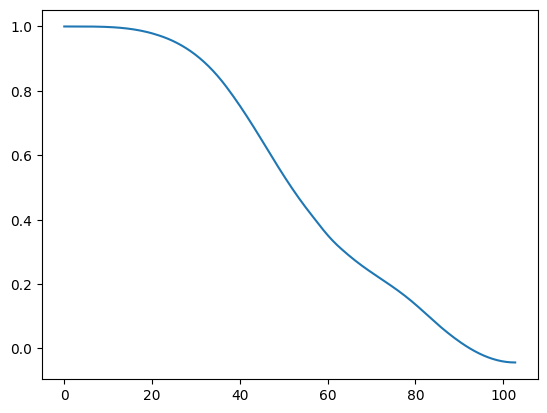

In [18]:
%matplotlib inline
plt.plot(tsa, qa[:,0], '-')
plt.show()

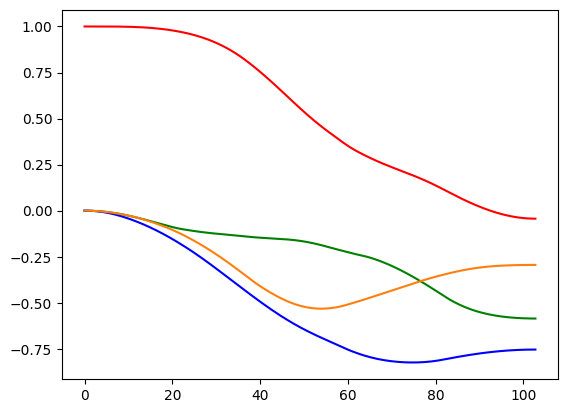

In [19]:
%matplotlib inline
plt.plot(tsa, qa[:,0], 'r')
plt.plot(tsa, qa[:,1], 'g')
plt.plot(tsa, qa[:,2], 'b')
plt.plot(tsa, qa[:,3], 'tab:orange')
plt.show()

In [20]:
tsb, Vb = sol.sample(V, grid='control')

In [ ]:
Vb

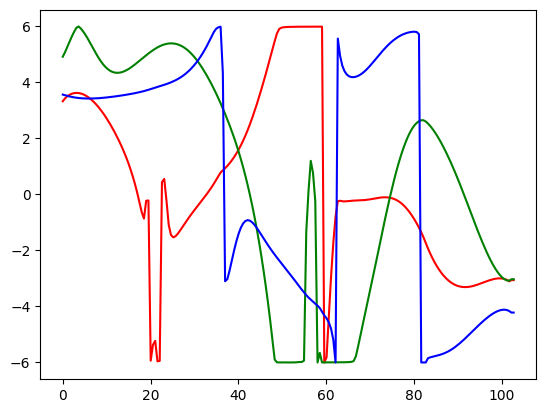

In [21]:
%matplotlib inline
plt.plot(tsb, Vb[:,0], 'r')
plt.plot(tsb, Vb[:,1], 'g')
plt.plot(tsb, Vb[:,2], 'b')
plt.show()

In [22]:
tsc, wc = sol.sample(w, grid='control')

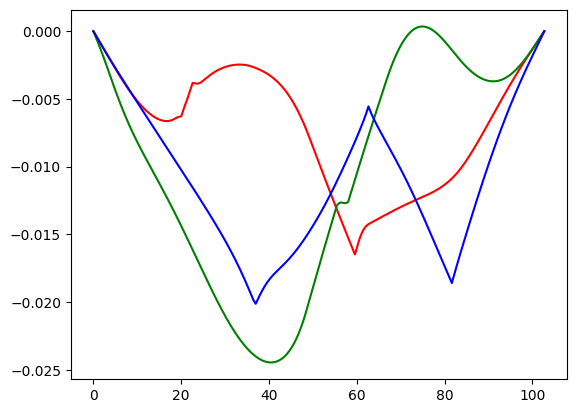

In [23]:
%matplotlib inline
plt.plot(tsc, wc[:,0], 'r')
plt.plot(tsc, wc[:,1], 'g')
plt.plot(tsc, wc[:,2], 'b')
plt.show()

In [25]:
tsd, Omegad = sol.sample(Omega, grid='control')

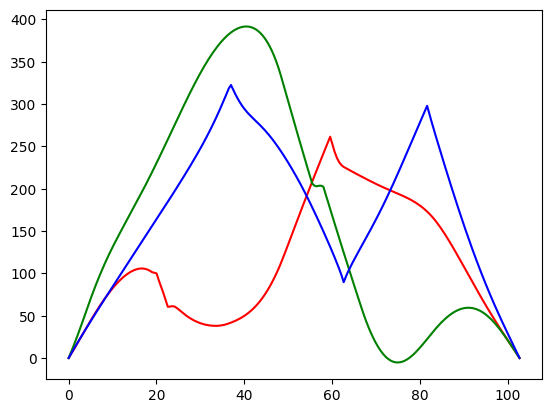

In [26]:
%matplotlib inline
plt.plot(tsd, Omegad[:,0], 'r')
plt.plot(tsd, Omegad[:,1], 'g')
plt.plot(tsd, Omegad[:,2], 'b')
plt.show()

In [ ]:
np.linalg.norm(np.array([-0.0434363, -0.5855824, -0.7539713, -0.2945059]))